<a href="https://colab.research.google.com/github/yasharzb/MNIST-Rotate-UNet/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl" text-align="justify">


مقدمات
===================

</div>

<div dir='rtl' text-algin='justify'>

ابتدا کتابخانه‌های مورد نیاز را وارد می‌کنیم. خانواده‌ی `torch` و `numpy` و `matplotlib` که مشخص هستند. از `random` برای ایجاد زاویه‌ی تصادفی، از `time` برای اندازه‌گیری زمان آموزش و از `tqdm`برای نشان دادن پروسه‌ی یادگیری استفاده شده است.

</div>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as func
import torchvision.datasets as datasets
import torchvision as torchvision
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import numpy as np
import matplotlib
import random
from matplotlib import pyplot as plt
from torch.nn import MSELoss, CrossEntropyLoss, BCEWithLogitsLoss
import torch.optim as optim
from tqdm import tqdm
import time

<div dir='rtl' text-algin='justify'>

با توجه به سنگینی کار، در این قسمت ترجیح داده شده است که از `gpu` برای تسریع استفاده شود.

</div>

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


<div dir='rtl' text-algin='justify'>

در این قسمت دو پارامتر ست شده‌اند. یکی `batch size` که در این مسئله سه مقدار ۱۲۸، ۶۴ و ۳۲ بررسی شدند که ۶۴ از همه بهتر (هم از نظر دقت هم از نظر زمان همگرایی) عمل کرد. و دیگری هم که اندازه‌ی ابعاد تصاویر `mnist_size` است که به صورت مربع های ۲۸ در ۲۸ هستند.

</div>

In [3]:
base_dir = './'
batch_size = 32
mnist_size = 28
base_transform = transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)),])

<div dir="rtl" text-align="justify">

ساخت مدل‌ها
===============

</div>

<div dir='rtl' text-algin='justify'>

برای شروع، یک دیتاست تغییر یافته از `MNIST` را ایجاد می‌کنیم. قرار است از این جهت آموزش و آزمایش استفاده شود. هر تصویر `MNIST` گرفته می‌شود و اصل آن به عنوان `target` تعیین می‌شود. سپس با زاویه‌ای تصادفی می‌چرخد و این تصویر جدید به عنوان ورودی تعبیر می‌شود.

</div>

In [4]:
class SegmentationMNIST(datasets.MNIST):
    def __getitem__(self, index: int):
        inp, tar = super(SegmentationMNIST, self).__getitem__(index)
        angle = random.uniform(-90, 90)
        tar = inp
        inp = transforms.functional.rotate(inp, angle)
        return inp, tar

In [5]:
train_loader = DataLoader(SegmentationMNIST('./data', train=True, download=True, transform=base_transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SegmentationMNIST('./data', train=False, download=True, transform=base_transform), batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/SegmentationMNIST/raw/train-images-idx3-ubyte.gz to ./data/SegmentationMNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/SegmentationMNIST/raw/train-labels-idx1-ubyte.gz to ./data/SegmentationMNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/SegmentationMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/SegmentationMNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/SegmentationMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/SegmentationMNIST/raw



<div dir='rtl' text-algin='justify'>

پیش از شروع می‌بایست حدود مدل خود را پیدا کنیم. همانطور که می‌دانیم می‌توان از هر دو مدل `Discriminitive`و `Generative` استفاده کرد. اما چون قرار نیست مسئله‌ی رگرسیون (نوع اول) حل شود، پس از نوع دوم استفاده می‌کنیم. برای نوع دوم می‌توان از مدل‌های گوناگونی مانند `GAN` و یا `Autoencoder`ها استفاده کرد.

با توجه به مطالبی که در راستای آموزش `pytorch` گفته شد، من سراغ `U-Net` رفتم که یک نوع ‍`Autoencoder` به حساب می‌آید. به صورت کلی شیوه‌ی کار آن به این صورت است که یک تصویر می‌گیرد، با لایه‌های کانولوشنی متعدد آن را به یک `vector` تبدیل می‌کند. در این مقطع ویژگی‌های اصلی با کمک کانولوشن و pooling به دست می‌آیند. سپس تلاش می‌کند با ویژگی‌های یادگرفته شده تصویر را مجددا بازسازی کند.

ساختار `U-Net` به صورت زیر است.

</div>

<div dir='rtl' text-algin='justify'>

برای سادگی می‌توان آن را به صورت زیر نشان داد.

همانگونه که می‌بینید ما یک سری زیرشبکه‌ی تکرار شونده داریم (دو کانولوشن) بین این زیرشبکه‌ها، یک `Max pooling`یا `up convolution` داریم.

</div>

<div dir='rtl' text-algin='justify'>

زیرشبکه‌های تکرار شونده را `Block` می‌نامیم. که حاوی دو لایه‌ی کانولوشن با پهنای ۳ است. ضخامت آن در هر مرحله تفاوت دارد.

</div>

In [6]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = func.relu(x)
        x = self.conv2(x)
        x = func.relu(x)
        return x

<div dir='rtl' text-algin='justify'>

اکنون `Encoder` را تعریف می‌کنیم. یک توالی از `Block`ها که بین آن‌ها یک `Max pooling` قرار می‌دهد (البته بجز مرحله‌ی آخر).

In [7]:
class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for i in range(len(self.enc_blocks) - 1):
            block = self.enc_blocks[i]
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        x = self.enc_blocks[-1](x)
        return x, ftrs

<div dir='rtl' text-algin='justify'>


بخش `Decoder` جدا از اینکه با کمک `up convolution` تصاویر را بزرگ ولی تعدد را کم می‌کند برای جبران مافات (حاصل از بزرگ‌سازی تصویر) از وسط تصویر پیشین در مرحله‌ی متناظر فعلی در `encoder` برش می‌دهد. این احتمالا به این منظور است که اثرات حواشی لبه‌ی تصویر در بازسازی دخیل نشود.

In [8]:
class Decoder(nn.Module):
    def __init__(self, chs = (256, 128, 64)):
        super().__init__()
        self.chs        = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

<div dir='rtl' text-algin='justify'>

در نهایت از اجتماع شبکه‌ی بالا `UNet` نهایی را می‌سازیم.

</div>

In [9]:
class UNet(nn.Module):
    def __init__(self, out_sz=mnist_size, enc_chs=(3, 64, 128, 256), dec_chs=(256, 128, 64), num_class=1, 
                 retain_dim=False):
        super().__init__()
        self.conv_i      = nn.Conv2d(num_class, 3, 3, padding=1)
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], enc_chs[0], 3, padding=1)
        self.conv_f      = nn.Conv2d(enc_chs[0], num_class, 3, padding=1)
        

    def forward(self, x):
        x        = self.conv_i(x)
        x, enc_ftrs = self.encoder(x)
        out      = self.decoder(x, enc_ftrs[::-1])
        out      = self.head(out)
        out      = self.conv_f(out)
        return out

<div dir="rtl" text-align="justify">

فاز آموزش
================

</div>

<div dir='rtl' text-algin='justify'>

ابتدا شبکه را ایجاد می‌کنیم و مشخصات آن را چاپ می‌کنیم.

</div>

In [10]:
unet = UNet().to(device)

print(unet)

UNet(
  (conv_i): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2,

<div dir='rtl' text-algin='justify'>

در این مرحله نرخ یادگیری را پایین می‌گذاریم تا در فرآیند گرادیان کاهشی از نقطه‌ی بهینه‌ی محلی عبور نکنیم. یک آستانه‌ی ۰/۰۰۱ تعریف می‌کنیم که نشان دهنده‌ی این است که اگ تغییرات تابع خطا از چه حدی کمتر بود فرآیند یادگیری را متوقف کند. در عین حال برای ۲۰ مرتبه فرآیند آموزش را تکرار می‌کنیم.

از تابع `MSE` برای خطا استفاده شده است. با وجود اینکه راه حل مسئله رگرسیون نیست ولی در نهایت نگاه بدین گونه است. یعنی قرار است فاصله‌ی دو تا ماتریس ۶۴×۱×۲۸×۲۸ بررسی شود. در صورتی که مسئله‌ی دسته بندی داشتیم احتمالا معقول‌تر بود که از `Cross Entropy` استفاده می‌کردیم.

در ابتدا جهت تسریع در همگرا شدن از `Adam` استفاده شده است. با توجه به اینکه دقت به نظر مناسب می‌آید و `SGD` روش کندتری است، تغییری در این جا اعمال نشده است.

In [11]:
lr = 0.001
loss_func = MSELoss()
opt = optim.Adam(unet.parameters(), lr)
train_steps = len(train_loader)
test_steps = len(test_loader)
total_loss = {'train': [], 'test': []}
epochs = 20
threshold = 0.001

<div dir='rtl' text-algin='justify'>

در هر گام، به اندازه‌ی `batch size` به شبکه جهت یادگیری می‌دهیم،  خطا را محاسبه می‌کنیم و متناسب با آن پیش می‌رویم. پس از اتمام یادگیری، خطای آزمایش را هم محاسبه می‌کنیم.

</div>

In [12]:
print("[INFO] training the network...")
start_time = time.time()
for epoch in range(epochs):
    unet.train()
    
    train_loss = 0
    test_loss = 0
    for i, data in tqdm(enumerate(train_loader), total=train_steps):
        inps, tars = data
        inps, tars = inps.to(device), tars.to(device)
        pred = unet(inps)
        loss = loss_func(pred, tars)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        train_loss += loss
    
    with torch.no_grad():
        unet.eval()
        for inp, tar in test_loader:
            inp, tar = inp.to(device), tar.to(device)
            pred = unet(inp)
            test_loss += loss_func(pred, tar)
    
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    
    total_loss['train'].append(avg_train_loss.cpu().detach().numpy())
    total_loss['test'].append(avg_test_loss.cpu().detach().numpy())
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avg_train_loss, avg_test_loss))
    if epoch != 0 and total_loss['train'][- 2] - total_loss['train'][- 1] < threshold:
      break

end_time = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

[INFO] training the network...


100%|██████████| 1875/1875 [03:19<00:00,  9.41it/s]


[INFO] EPOCH: 1/20
Train loss: 0.169682, Test loss: 0.0916


100%|██████████| 1875/1875 [03:19<00:00,  9.40it/s]


[INFO] EPOCH: 2/20
Train loss: 0.069910, Test loss: 0.0548


100%|██████████| 1875/1875 [03:19<00:00,  9.40it/s]


[INFO] EPOCH: 3/20
Train loss: 0.048714, Test loss: 0.0418


100%|██████████| 1875/1875 [03:19<00:00,  9.40it/s]


[INFO] EPOCH: 4/20
Train loss: 0.039452, Test loss: 0.0351


100%|██████████| 1875/1875 [03:19<00:00,  9.42it/s]


[INFO] EPOCH: 5/20
Train loss: 0.034141, Test loss: 0.0313


100%|██████████| 1875/1875 [03:19<00:00,  9.42it/s]


[INFO] EPOCH: 6/20
Train loss: 0.030427, Test loss: 0.0304


100%|██████████| 1875/1875 [03:19<00:00,  9.42it/s]


[INFO] EPOCH: 7/20
Train loss: 0.028388, Test loss: 0.0256


100%|██████████| 1875/1875 [03:19<00:00,  9.41it/s]


[INFO] EPOCH: 8/20
Train loss: 0.026638, Test loss: 0.0274


100%|██████████| 1875/1875 [03:18<00:00,  9.43it/s]


[INFO] EPOCH: 9/20
Train loss: 0.025089, Test loss: 0.0250


100%|██████████| 1875/1875 [03:18<00:00,  9.44it/s]


[INFO] EPOCH: 10/20
Train loss: 0.024059, Test loss: 0.0227


100%|██████████| 1875/1875 [03:19<00:00,  9.42it/s]


[INFO] EPOCH: 11/20
Train loss: 0.022801, Test loss: 0.0216


100%|██████████| 1875/1875 [03:19<00:00,  9.41it/s]


[INFO] EPOCH: 12/20
Train loss: 0.022411, Test loss: 0.0213
[INFO] total time taken to train the model: 2636.68s


<div dir="rtl" text-align="justify">

ترسیم خطا‌ها و ذخیره‌ی تصویر و مدل
==========================================

</div>

<div dir='rtl' text-algin='justify'>

همانگونه که می‌بیند مدل به خوبی پس از سپری کردن یک گام خطا را به خوبی کاهش داد و همینطور به سمت خطای بین ۲ تا ۳ درصد همگرا می‌شود. این نشان می‌دهد که `under-fit` نداریم. از طرفی با توجه به اینکه خطای آزمایش نیز مشابه خطای آموزش کم است نشان می‌دهد که احتمالا `over-fit` نداشتیم. در غیر اینصورت احتمالا لازم می‌شد که لایه‌های `dropout`نیز اضافه کنیم.

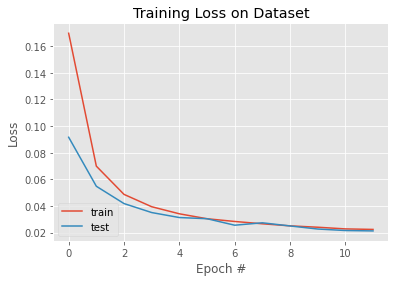

In [13]:
model_path = base_dir + 'model.pth'
plot_path = base_dir + 'plot.png'
plt.style.use("ggplot")
plt.figure()
plt.plot(total_loss["train"], label="train")
plt.plot(total_loss["test"], label="test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

<div dir="rtl" text-align="justify">

در کل سه `batch_size` متفاوت با مقادیر ۱۶ و ۳۲ و ۶۴ بررسی شده‌اند. مقادیر `train_loss` و `test_loss` بسیار نزدیک بوده‌اند. برای مقدار ۸ و ۱۲۸ مقادیر بدتر از این موارد بودند برای همین از گزارش آن‌ها صرف‌نظر شده است.

</div>

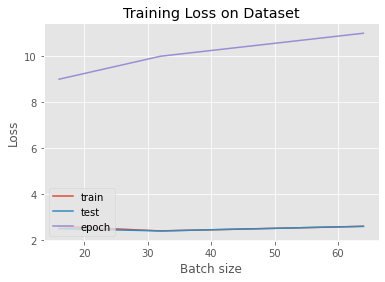

In [14]:
batch_sz = (16, 32, 64)
epochs = (9, 10, 11)
final_train_loss = (2.6, 2.4, 2.6)
final_test_loss = (2.5, 2.4, 2.6)
plot_path = base_dir + 'batch.png'
plt.figure()
plt.plot(batch_sz, final_train_loss, label="train")
plt.plot(batch_sz, final_test_loss, label="test")
plt.plot(batch_sz, epochs, label="epoch")
plt.title("Training Loss on Dataset")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)

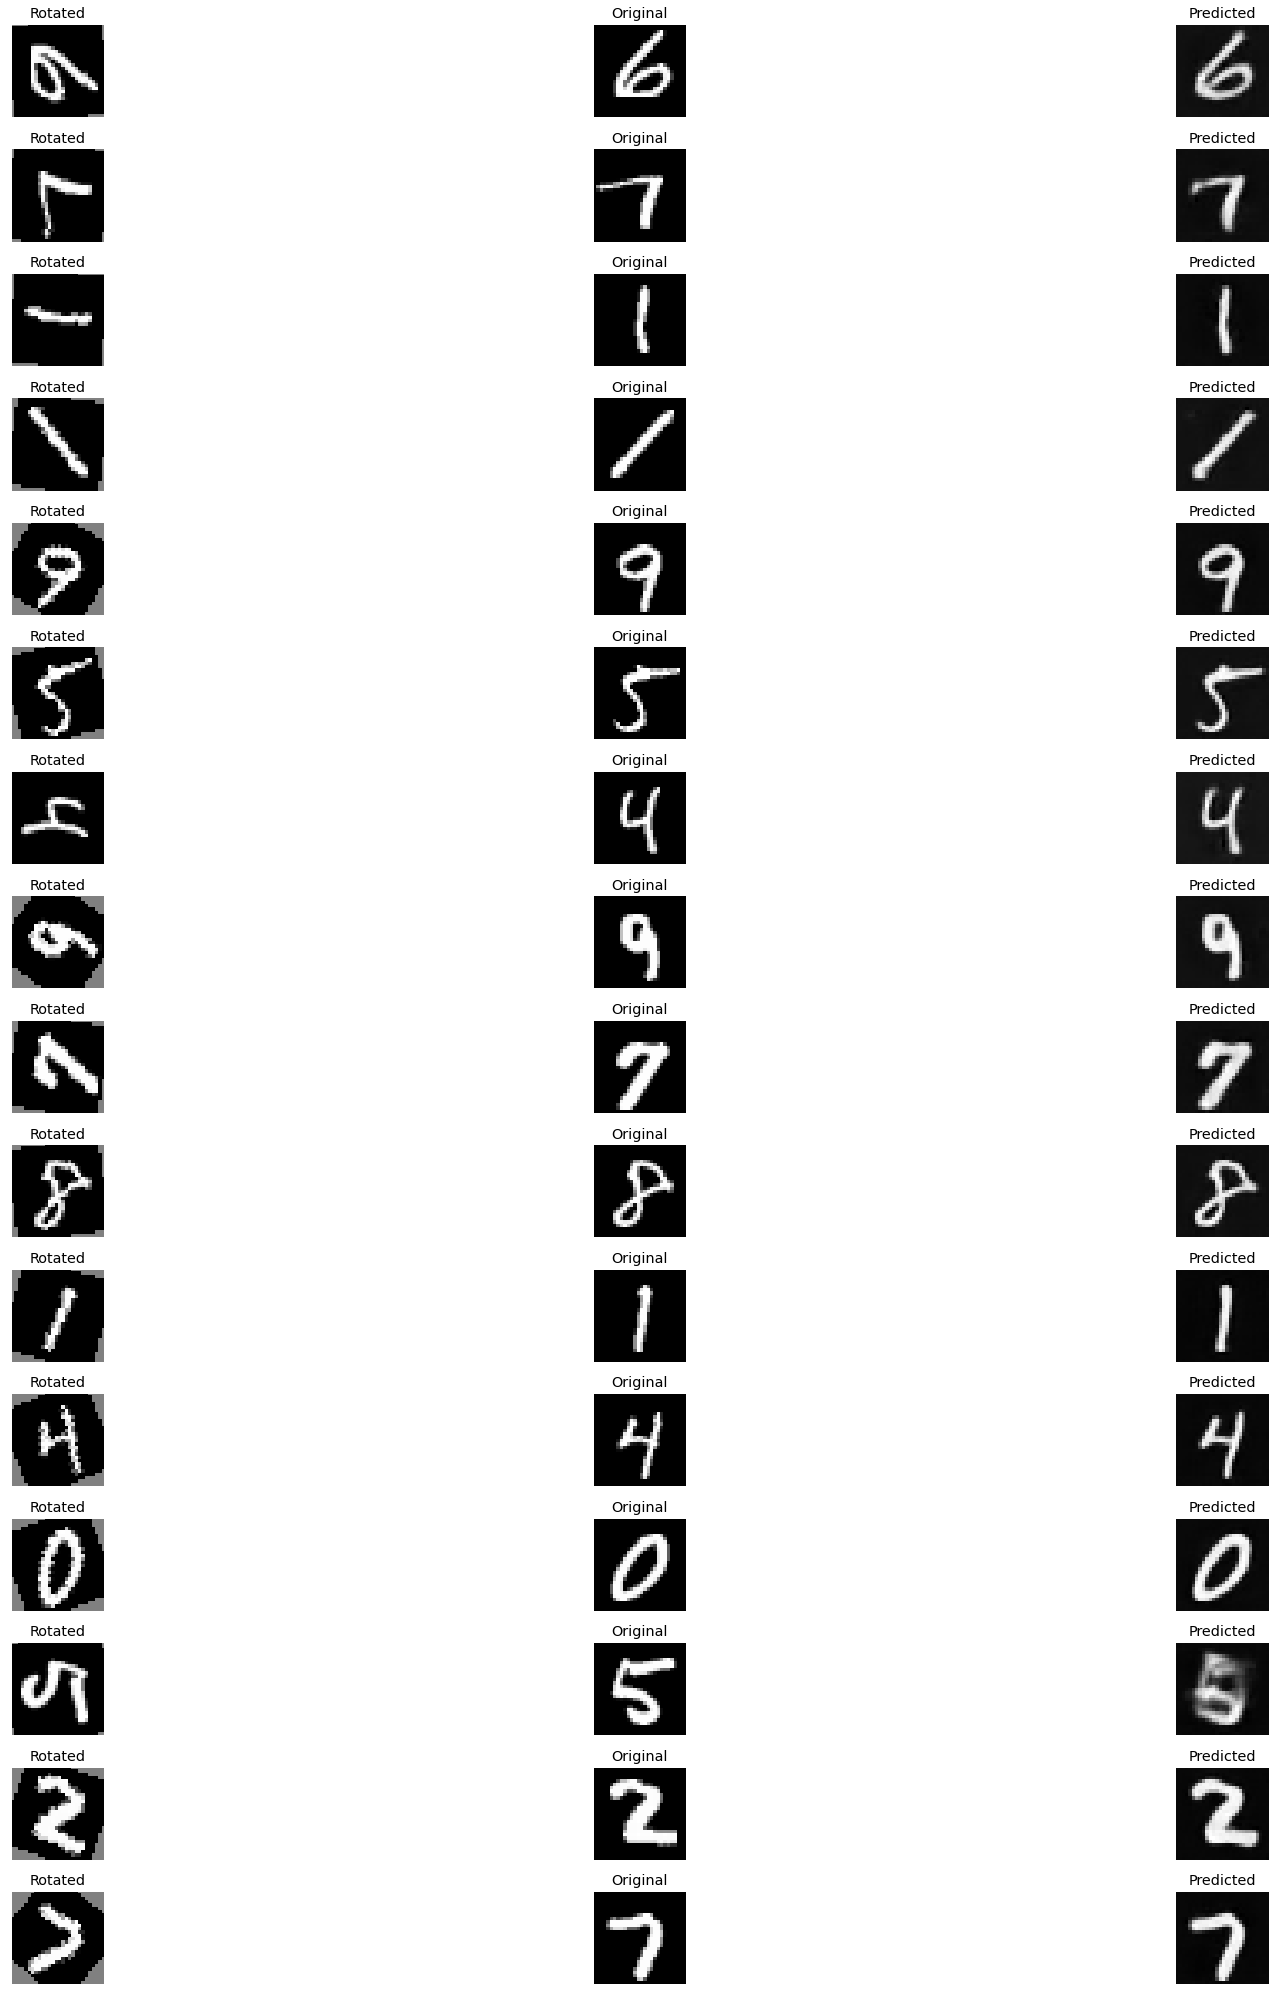

In [16]:
unet.eval()
total_sample = 16
fig = plt.figure(figsize=(mnist_size, mnist_size))
rand_idx = random.sample(range(0, (len(test_loader) - 1) * batch_size), total_sample)
lables = ('Rotated', 'Original', 'Predicted')
for i in range(total_sample):
    inp, tar = test_loader.dataset[rand_idx[i]]
    out = unet(inp.unsqueeze(1).to(device))
    images = (inp, tar, out[0].cpu().detach())
    for j in range(3):
      plt.subplot(total_sample, 3, i * 3 + j + 1)
      plt.tight_layout()
      plt.imshow(images[j].squeeze(), cmap='gray', interpolation='none')
      plt.title("{}".format(lables[j]))
      plt.xticks([])
      plt.yticks([])
    fig